In [132]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Importing relevant libraries. 

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import random

# creating pandas dataframes and cleaning up the data + feature engineering

In [134]:
# creating elementary  pandas dataframes 
import pandas as pd
from sklearn.model_selection import train_test_split

test_features = pd.read_csv('test_features.csv')
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [135]:
# In order to create a new feature such that the date recorded is in simple date_time format.
train_features['date_recorded'] = pd.to_datetime(train_features['date_recorded'], infer_datetime_format=True)
test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'], infer_datetime_format=True)

# creating a new feature wpp 
train_features['wpp'] = train_features['amount_tsh']/train_features['population']
test_features['wpp'] = test_features['amount_tsh']/test_features['population']  

# cleaning up the NaN and nonesense values
train_features['wpp'] = train_features['wpp'].replace([np.inf, -np.inf], np.nan)
test_features['wpp'] = test_features['wpp'].replace([np.inf, -np.inf], np.nan)

In [136]:
# checks to see if there are any 0 values in construction year, and checks NaNs values in wpp. 
def feature_eng_zeros(G):
    G['construction'] = G['construction_year'] != 0
    G['wpp'] = G['wpp'].replace(np.nan, 0)
    return G

# running the feature engineering function on the test and train features 
train_features = feature_eng_zeros(train_features)
test_features = feature_eng_zeros(test_features)


In [137]:
# cconverts each individual datetime feature into a string, such that the model as can use it. 
def feature_eng_convertDT(N):   
    N['year'] = N['date_recorded'].dt.year
    N['month'] = N['date_recorded'].dt.month
    N['week'] = N['date_recorded'].dt.week
    N['age'] = N['year'] -N['construction_year']
    N['age'].loc[N['age'] == N['year']] = 0
    N['date_recorded'] = N['date_recorded'].astype(str)
    return N

# running the function on the above. 
train_features = feature_eng_convertDT(train_features)
test_features = feature_eng_convertDT(test_features)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [138]:
# creating a function such that any NaN values get changed over to a random value and not means 
# the lambda function functions such that it replaces it with a random values within that particular column. 
def NaNFiller(X):
    X['public_meeting'] = X['public_meeting'].fillna(lambda x: random.choice(X[X['public_meeting'] != np.nan])['public_meeting'])
    X['permit'] = X['permit'].fillna(lambda x: random.choice(X[X['permit'] != np.nan])['permit'])
    X['age'] = X['age'].replace(0, round(X['age'].mean()))
    X['gps_height'] = X['gps_height'].replace(0, round(X['gps_height'].mean()))
    X['funder']= X['funder'].fillna('other')
    return X

# Running the NaNFillers function on the train_features. 
train_features = NaNFiller(train_features)
test_features = NaNFiller(test_features)

In [139]:
# defining a function, such that it drops on each function for train_features, test_features, train_labels. 
def drip_drop_columns(X):
    drop_cols = ['quantity_group','construction_year','recorded_by','id','num_private',
             'amount_tsh', 'wpt_name','subvillage','management_group']
    X = X.drop(columns= drop_cols)
    return X

# dropping the columsn using hte function. 
train_features = drip_drop_columns(train_features)
test_features = drip_drop_columns(test_features)
train_labels = train_labels.drop(columns='id')

# doing test train split split to begin model testing

ordinal encoding + MinMaxScaler instead of StandardScaler. 

In [140]:
# doing a test train split to begin parsing the columns. 
X_train, X_val, y_train, y_val = train_test_split(train_features,train_labels, random_state=42, test_size=.2)
X_test = test_features

In [141]:
train_features.shape, test_features.shape

((59400, 37), (14358, 37))

In [142]:
# using ordinal encoder as the encoder. 
encoder = ce.OrdinalEncoder()
# Fit & Transform
X_train = encoder.fit_transform(X_train)

# sestting the columns to then be scaled. 
cont_columns = ['population', 'gps_height', 'week', 'month', 'year', 'age'] 


# better scaler than the standard scaler --> as it changes the outlier. 
scaled = MinMaxScaler()
X_train[cont_columns] = scaled.fit_transform(X_train[cont_columns])

# code that will use all your CPUs. 

In [143]:
# making a dictionary for the param_distribution of the model
p_dist = {
    'n_estimators': [325], 
    'max_depth': [20]
}


# Instantiating the model and inputting inside the randomized search CV. 
model = RandomForestClassifier(n_jobs=-1, criterion="entropy")

# Randomized search CV. 
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=p_dist,
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    cv=20,
    verbose=4,
    return_train_score=True,
)

# fitting t o the training data. 
search.fit(X_train, y_train)
print('Training Accuracy Score:', search.best_score_) 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:   22.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   23.0s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   28.6s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   28.9s finished
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Training Accuracy Score: 0.812037037037037


In [144]:
 # encoding and transforming the X_val
X_val = encoder.transform(X_val)

# scaling and fiting the continous columns. 
X_val[cont_columns] = scaled.fit_transform(X_val[cont_columns])

In [145]:
# checking the score after scaling and fitting continous columsn. 
best = search.best_estimator_
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val, y_pred))

Validation Set Accuracy Score: 0.810016835016835


In [146]:
# getting X_test ready for making submission y_pred_test
best = search.best_estimator_
X_test = encoder.transform(X_test)

# scaling and fitting the y_pred test before exporting/ 
X_test[cont_columns] = scaled.fit_transform(X_test[cont_columns])
y_pred_test = best.predict(X_test)

# scoring and accuracy: 

In [149]:
from sklearn.metrics import plot_confusion_matrix

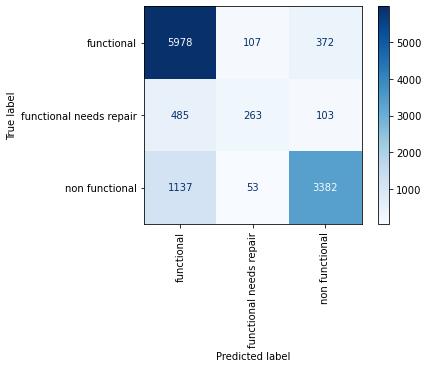

In [151]:
plot_confusion_matrix(search, X_val, y_val,
                      values_format='.0f', xticks_rotation='vertical', cmap='Blues')

In [152]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.93      0.85      6457
functional needs repair       0.62      0.31      0.41       851
         non functional       0.88      0.74      0.80      4572

               accuracy                           0.81     11880
              macro avg       0.76      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



In [154]:
import seaborn as sns

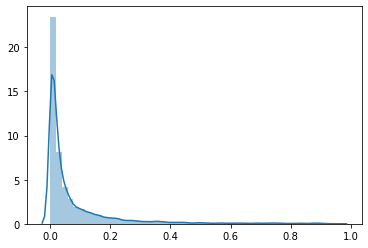

In [155]:
y_pred_proba = search.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba)

In [159]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba, multi_class='ovr')

AxisError: axis 1 is out of bounds for array of dimension 1

# making the submission_files

In [147]:
submission = sample_submission.copy()
submission['status_group'] = y_pred_test
submission.to_csv('Submission_Kush_ensemble_8.csv', index=False)